Пропущенные значения до обработки:
precipitation    0
temp_max         0
temp_min         0
wind             0
weather          0
dtype: int64


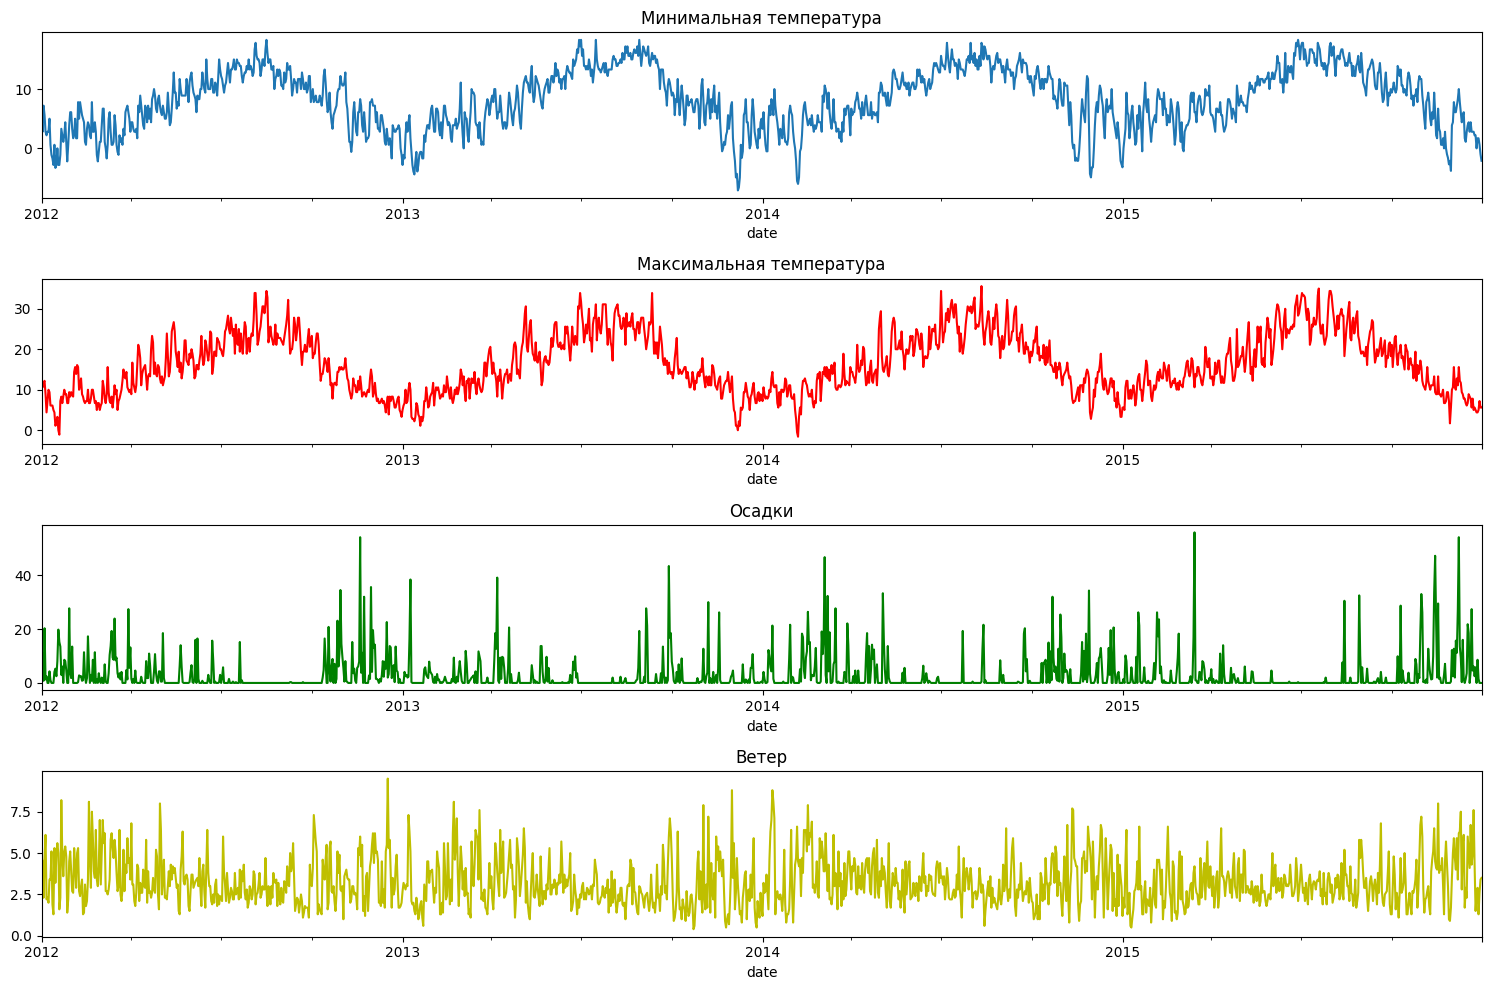

In [40]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.vector_ar.var_model import VAR
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, GRU, Dense
from sklearn.preprocessing import MinMaxScaler
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.preprocessing import LabelEncoder

#загрузка данных
path = 'seattle-weather.csv'
data = pd.read_csv (path)
data['date'] = pd.to_datetime(data['date'])
data.set_index('date', inplace=True)
#ts = data['temp_max']

#проверка на пропущенные значения
print ('Пропущенные значения до обработки:')
print (data.isnull().sum())

#заполнение пропущенных значений (числовые заполняем средним значением, категориальные - модой)
for col in data:
  data[col] = data[col].fillna(data[col].mean() if data[col].dtype in ['int64', 'float64'] else data[col].mode()[0])

#преобразуем категориальные признаки
le = LabelEncoder()
data['weather'] = le.fit_transform(data['weather'])

#визуализация исходных данных
plt.figure(figsize=(15, 10))
plt.subplot(4, 1, 1)
data['temp_min'].plot(title='Минимальная температура')
plt.subplot(4, 1, 2)
data['temp_max'].plot(title='Максимальная температура', color='r')
plt.subplot(4, 1, 3)
data['precipitation'].plot(title='Осадки', color='g')
plt.subplot(4, 1, 4)
data['wind'].plot(title='Ветер', color='y')
plt.tight_layout()
plt.show()


Результаты теста Дики-Фуллера:
Test Statistic         -2.605620
p-value                 0.091841
Critical Value (1%)    -3.434877
Critical Value (5%)    -2.863539
Critical Value (10%)   -2.567835
dtype: float64


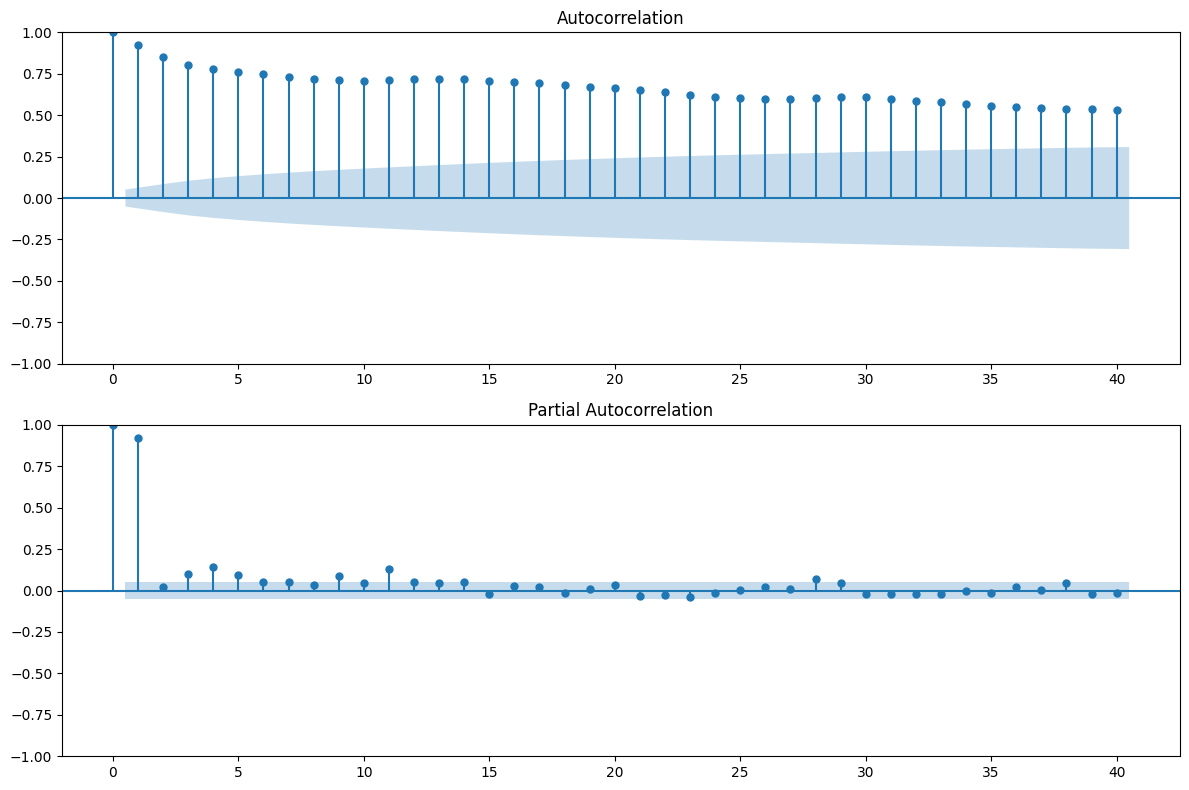

In [11]:
#проверка стационарности временного ряда с помощью теста Дики-Фуллера
def test_stationarity(timeseries):
    print('Результаты теста Дики-Фуллера:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:2], index=['Test Statistic', 'p-value'])
    for key, value in dftest[4].items():
        dfoutput['Critical Value (%s)' % key] = value
    print(dfoutput)

test_stationarity(data['temp_min'])

# Визуализация ACF и PACF
plt.figure(figsize=(12, 8))
plt.subplot(211)
plot_acf(data['temp_min'], lags=40, ax=plt.gca())
plt.subplot(212)
plot_pacf(data['temp_min'], lags=40, ax=plt.gca())
plt.tight_layout()
plt.show()

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


                               SARIMAX Results                                
Dep. Variable:               temp_min   No. Observations:                 1096
Model:               ARIMA(12, 1, 11)   Log Likelihood               -2227.025
Date:                Tue, 06 May 2025   AIC                           4502.051
Time:                        17:43:59   BIC                           4622.015
Sample:                    01-01-2012   HQIC                          4547.444
                         - 12-31-2014                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.8320      0.267      3.112      0.002       0.308       1.356
ar.L2         -0.0542      0.268     -0.202      0.840      -0.579       0.470
ar.L3         -0.0722      0.120     -0.602      0.5

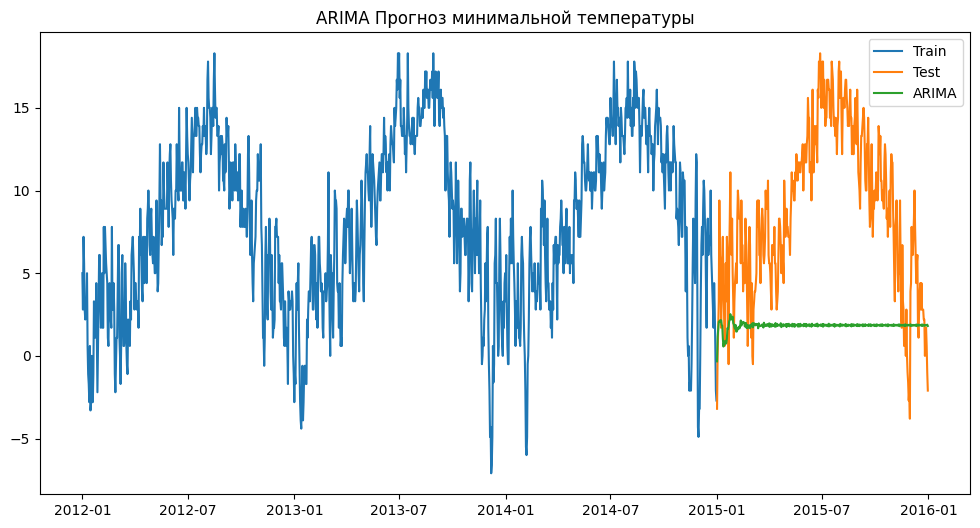

In [49]:
#ARIMA
#прогнозирование минимальной температуры

train = data['temp_min'][:-365] #все данные кроме последних 365 дней
test = data['temp_min'][-365:]  #последние 365 дней

#обучение
model_arima = ARIMA(train, order=(12,1,11))
results_arima = model_arima.fit()
print(results_arima.summary())

#прогноз на год
forecast_arima = results_arima.forecast(steps=365)

#визуализация
plt.figure(figsize=(12, 6))
plt.plot(train.index, train, label='Train')
plt.plot(test.index, test, label='Test')
plt.plot(forecast_arima.index, forecast_arima, label='ARIMA')
plt.title('ARIMA Прогноз минимальной температуры')
plt.legend()
plt.show()


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


                                     SARIMAX Results                                      
Dep. Variable:                           temp_min   No. Observations:                 1096
Model:             SARIMAX(1, 1, 1)x(5, 1, 1, 12)   Log Likelihood               -2250.831
Date:                            Tue, 06 May 2025   AIC                           4519.663
Time:                                    17:45:18   BIC                           4564.550
Sample:                                01-01-2012   HQIC                          4536.657
                                     - 12-31-2014                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.7055      0.034     21.022      0.000       0.640       0.771
ma.L1         -0.9177      0.020   

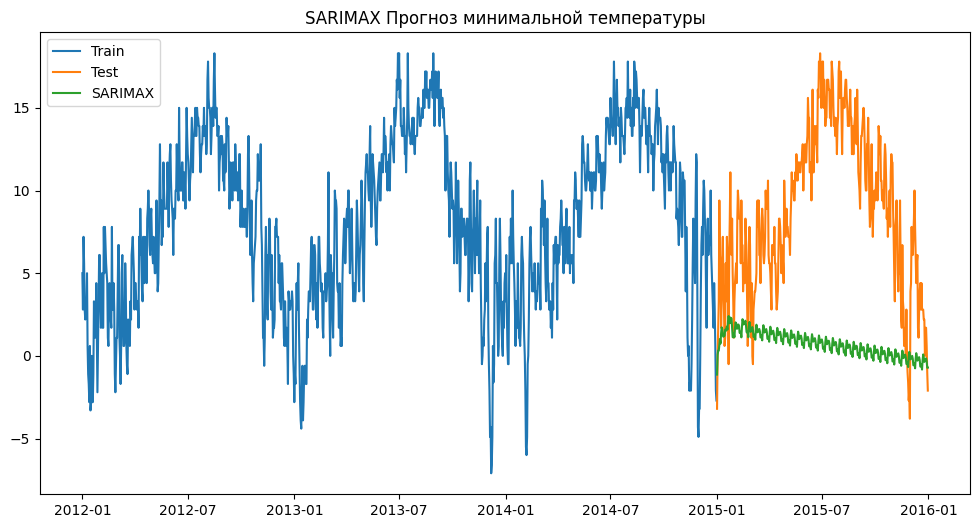

In [50]:
#SARIMA

#обучение
model_sarimax = SARIMAX(train, order=(1,1,1), seasonal_order=(5,1,1,12))
results_sarimax = model_sarimax.fit(disp=False)
print(results_sarimax.summary())

#прогноз на год
forecast_sarimax = results_sarimax.get_forecast(steps=365).predicted_mean

# Визуализация результатов
plt.figure(figsize=(12, 6))
plt.plot(train.index, train, label='Train')
plt.plot(test.index, test, label='Test')
plt.plot(forecast_sarimax.index, forecast_sarimax, label='SARIMAX')
plt.title('SARIMAX Прогноз минимальной температуры')
plt.legend()
plt.show()

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Tue, 06, May, 2025
Time:                     17:45:18
--------------------------------------------------------------------
No. of Equations:         4.00000    BIC:                    8.10329
Nobs:                     1084.00    HQIC:                   7.58855
Log likelihood:          -9915.55    FPE:                    1443.97
AIC:                      7.27496    Det(Omega_mle):         1227.15
--------------------------------------------------------------------
Results for equation temp_min
                       coefficient       std. error           t-stat            prob
------------------------------------------------------------------------------------
const                    -0.000553         0.053601           -0.010           0.992
L1.temp_min              -0.234489         0.033427           -7.015           0.000
L1.temp_max               0.188388       

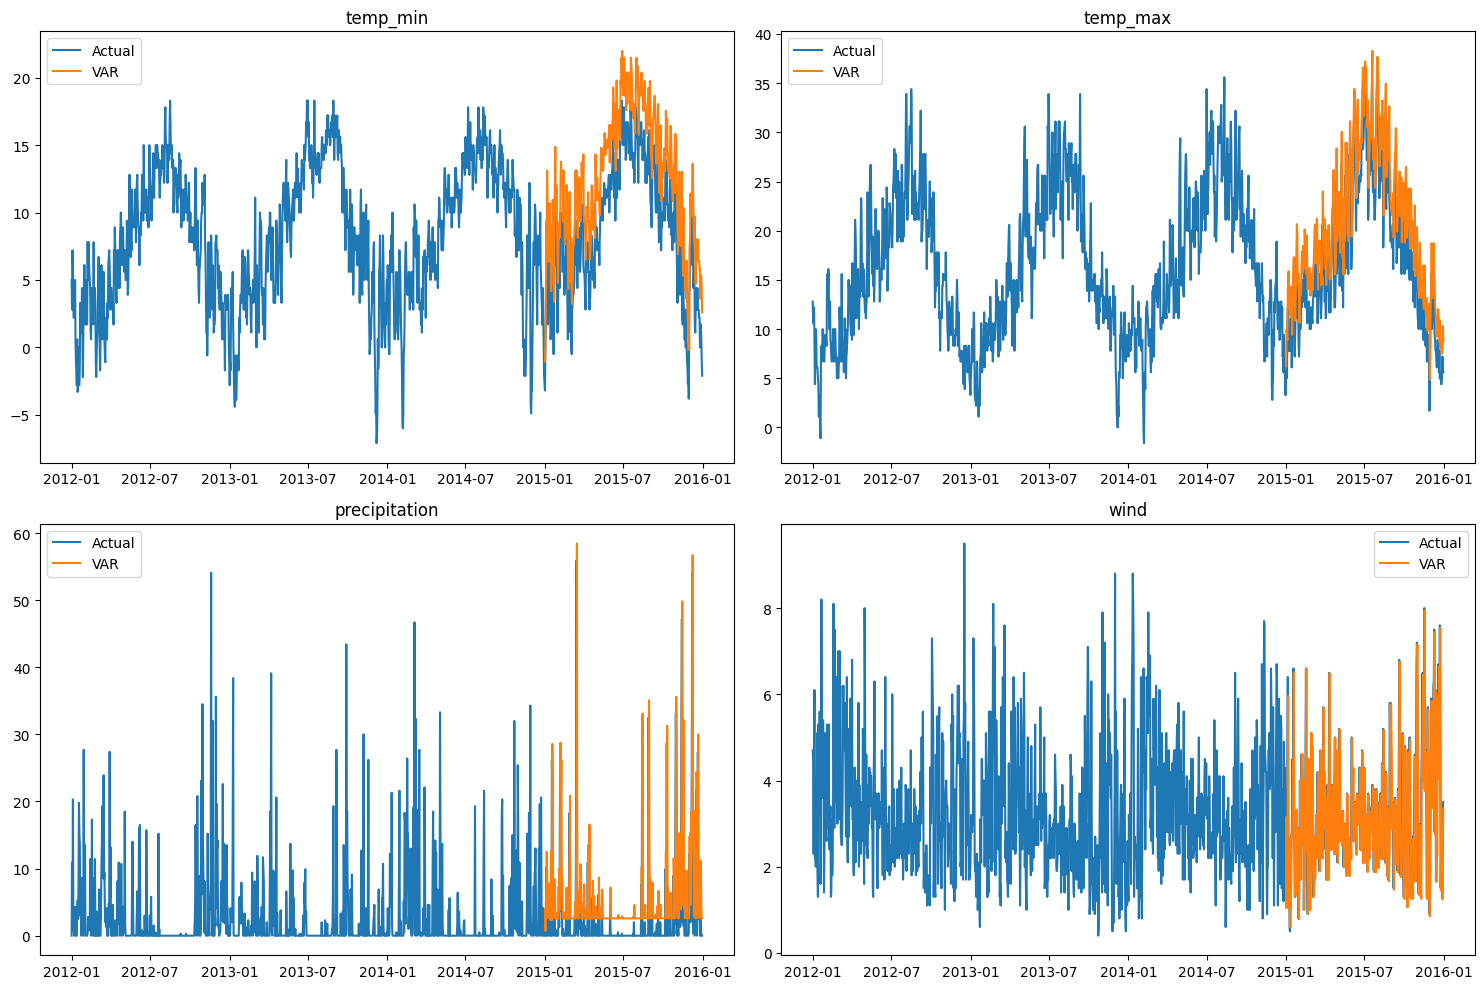

In [51]:
#VAR

#подготовка данных
var_data = data[['temp_min', 'temp_max','precipitation', 'wind']]

#тест на стационарность и дифферинцирование
var_data_diff = var_data.diff().dropna()

#разделение на train/test
train_var = var_data_diff[:-365]
test_var = var_data_diff[-365:]

#обучение
model_var = VAR(train_var)
results_var = model_var.fit(maxlags=15, ic='aic')
print(results_var.summary())

#прогноз на год
lag_order = results_var.k_ar
forecast_var = results_var.forecast(train_var.values[-lag_order:], steps=365)

#преобразование прогноза в исходный масштаб
forecast_var = pd.DataFrame(forecast_var, index=test_var.index, columns=test_var.columns)
forecast_var = var_data.iloc[-366:-1].values + forecast_var.cumsum()

#визуализация
plt.figure(figsize=(15, 10))
for i, col in enumerate(var_data.columns):
    plt.subplot(2, 2, i+1)
    plt.plot(var_data.index, var_data[col], label='Actual')
    plt.plot(test_var.index, forecast_var[col], label='VAR')
    plt.title(col)
    plt.legend()
plt.tight_layout()
plt.show()

Epoch 1/60


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


34/34 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step - loss: 0.2096
Epoch 2/60
34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 0.0122
Epoch 3/60
34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - loss: 0.0096
Epoch 4/60
34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.0095
Epoch 5/60
34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 0.0099
Epoch 6/60
34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.0093
Epoch 7/60
34/34 ━━━━━━━━━━━━━━━━━━━━ 2s 35ms/step - loss: 0.0088
Epoch 8/60
34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.0085
Epoch 9/60
34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0089
Epoch 10/60
34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0090
Epoch 11/60
34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0090
Epoch 12/60
34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0086
Epoch 13/60
34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0085
Epoch 14/60
34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0083
Epoch 15/60
34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 0.0083
Epoch 16/60
34/

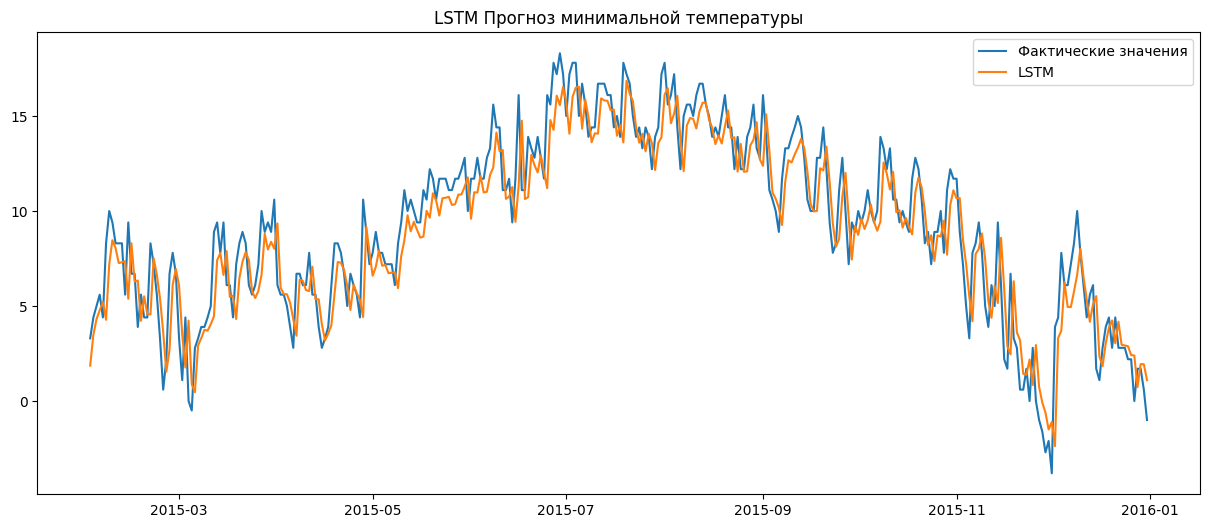

In [52]:
#LSTM

#подготовка данных
def prepare_data(data, n_steps):
    X, y = [], []
    for i in range(len(data)-n_steps-1):
        X.append(data[i:(i+n_steps)])
        y.append(data[i+n_steps])
    return np.array(X), np.array(y)

#нормализация данных
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(data[['temp_min']])

#параметры
n_steps = 30  #используем 30 дней для предсказания следующего
test_size = 365  #год для теста

#разделение данных
train_data = scaled_data[:-test_size]
test_data = scaled_data[-test_size:]

#подготовка последовательностей
X_train, y_train = prepare_data(train_data, n_steps)
X_test, y_test = prepare_data(test_data, n_steps)

#изменение формы для LSTM/GRU [samples, timesteps, features]
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

#LSTM
lstm_model = Sequential()
lstm_model.add(LSTM(50, activation='relu', input_shape=(n_steps, 1)))
lstm_model.add(Dense(1))
lstm_model.compile(optimizer='adam', loss='mse')

#обучение LSTM
lstm_model.fit(X_train, y_train, epochs=60, verbose=1)

#прогнозирование LSTM
lstm_forecast = lstm_model.predict(X_test)

#обратное преобразование данных
def inverse_transform(forecast, scaler, test_data, n_steps):
    #создаем базовый массив и вставляем прогнозы
    empty_array = np.zeros((len(forecast)+n_steps, 1))
    empty_array[-len(forecast):] = forecast
    return scaler.inverse_transform(empty_array)[-len(forecast):]

lstm_forecast = inverse_transform(lstm_forecast, scaler, test_data, n_steps)
y_test_inv = inverse_transform(y_test, scaler, test_data, n_steps)

#визуализация
plt.figure(figsize=(15, 6))
plt.plot(data.index[-len(y_test_inv):], y_test_inv, label='Фактические значения')
plt.plot(data.index[-len(lstm_forecast):], lstm_forecast, label='LSTM')
plt.title('LSTM Прогноз минимальной температуры')
plt.legend()
plt.show()

Epoch 1/60


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


34/34 ━━━━━━━━━━━━━━━━━━━━ 4s 19ms/step - loss: 0.2496
Epoch 2/60
34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.0166
Epoch 3/60
34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.0118
Epoch 4/60
34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.0094
Epoch 5/60
34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.0079
Epoch 6/60
34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.0076
Epoch 7/60
34/34 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - loss: 0.0074
Epoch 8/60
34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - loss: 0.0065
Epoch 9/60
34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - loss: 0.0076
Epoch 10/60
34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - loss: 0.0070
Epoch 11/60
34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0069
Epoch 12/60
34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.0067
Epoch 13/60
34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 0.0062
Epoch 14/60
34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.0057
Epoch 15/60
34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.0063
Epoch 16/60
34/

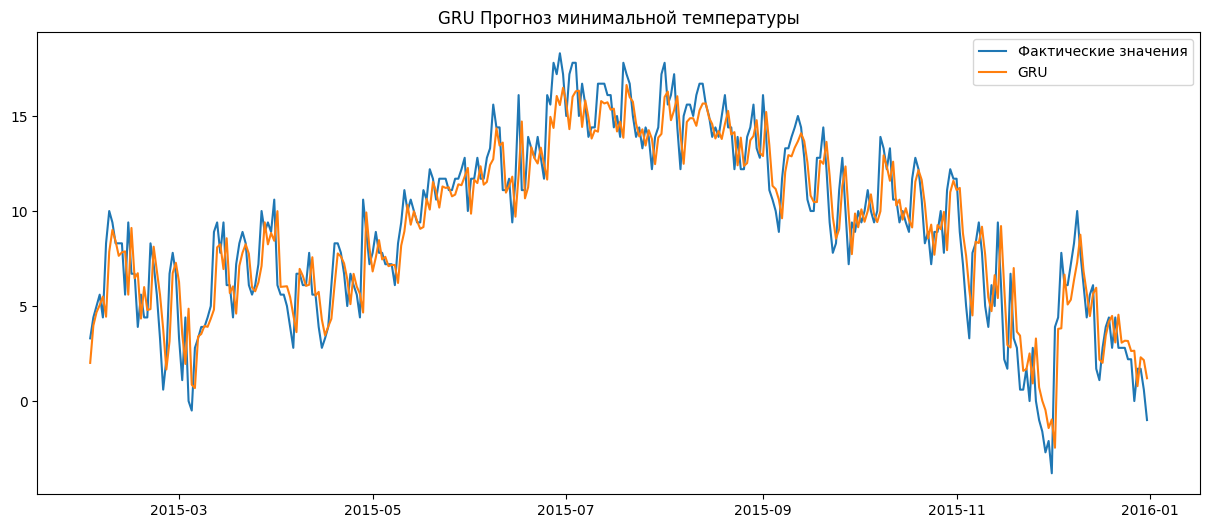

In [53]:
#GRU

gru_model = Sequential()
gru_model.add(GRU(50, activation='relu', input_shape=(n_steps, 1)))
gru_model.add(Dense(1))
gru_model.compile(optimizer='adam', loss='mse')

#обучение
gru_model.fit(X_train, y_train, epochs=60, verbose=1)

#прогнозирование
gru_forecast = gru_model.predict(X_test)

#обратное преобразование данных
def inverse_transform(forecast, scaler, test_data, n_steps):
    #создаем базовый массив и вставляем прогнозы
    empty_array = np.zeros((len(forecast)+n_steps, 1))
    empty_array[-len(forecast):] = forecast
    return scaler.inverse_transform(empty_array)[-len(forecast):]

gru_forecast = inverse_transform(gru_forecast, scaler, test_data, n_steps)
y_test_inv = inverse_transform(y_test, scaler, test_data, n_steps)

#визуализация
plt.figure(figsize=(15, 6))
plt.plot(data.index[-len(y_test_inv):], y_test_inv, label='Фактические значения')
plt.plot(data.index[-len(gru_forecast):], gru_forecast, label='GRU')
plt.title('GRU Прогноз минимальной температуры')
plt.legend()
plt.show()


In [57]:
#оценка точности
def evaluate_forecast(actual, forecast, model_name):
    mae = mean_absolute_error(actual, forecast)
    mse = mean_squared_error(actual, forecast)
    rmse = np.sqrt(mse)
    print(f'{model_name}')
    print(f'MAE: {mae:.2f}')
    print(f'MSE: {mse:.2f}')
    print(f'RMSE: {rmse:.2f}\n')

# Оценка ARIMA
evaluate_forecast(test, forecast_arima, 'ARIMA')

# Оценка SARIMAX
evaluate_forecast(test, forecast_sarimax, 'SARIMAX')

# Оценка VAR
evaluate_forecast(test_var['temp_min'], forecast_var[col], 'VAR (Min Temp)')

def evaluate_model(y_true, y_pred, model_name):
    mae = mean_absolute_error(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    print(f'{model_name}')
    print(f'MAE: {mae:.2f}')
    print(f'MSE: {mse:.2f}')
    print(f'RMSE: {rmse:.2f}\n')

evaluate_model(y_test_inv, lstm_forecast, 'LSTM')
evaluate_model(y_test_inv, gru_forecast, 'GRU')

ARIMA
MAE: 7.29
MSE: 71.90
RMSE: 8.48

SARIMAX
MAE: 8.24
MSE: 89.58
RMSE: 9.46

VAR (Min Temp)
MAE: 3.44
MSE: 16.58
RMSE: 4.07

LSTM
MAE: 1.42
MSE: 3.26
RMSE: 1.81

GRU
MAE: 1.36
MSE: 3.07
RMSE: 1.75



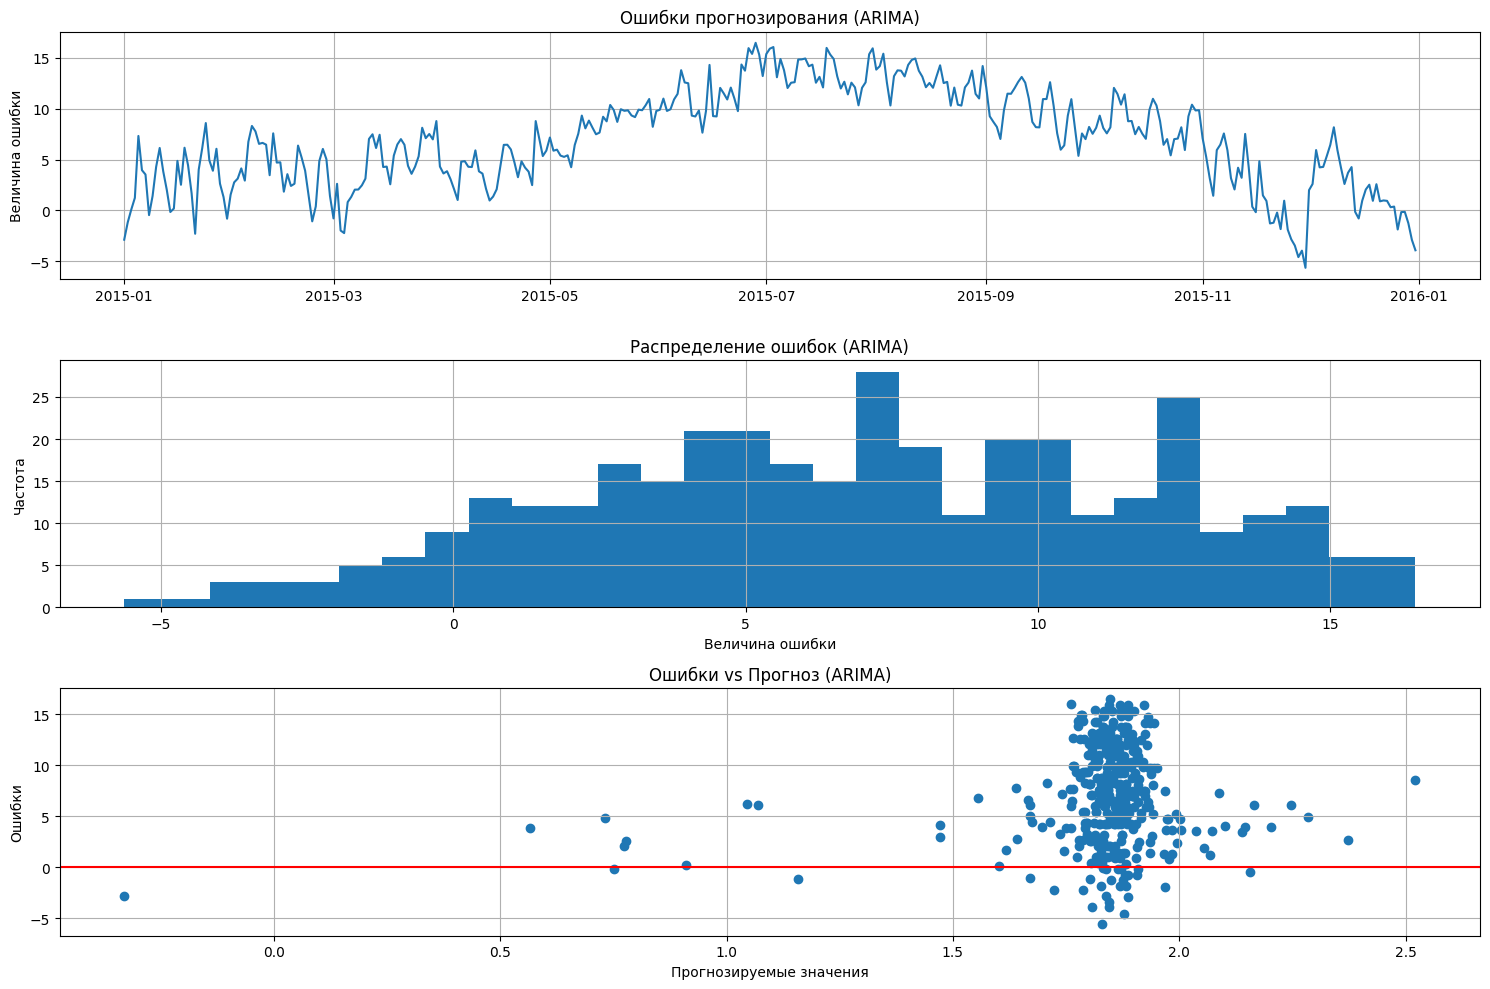

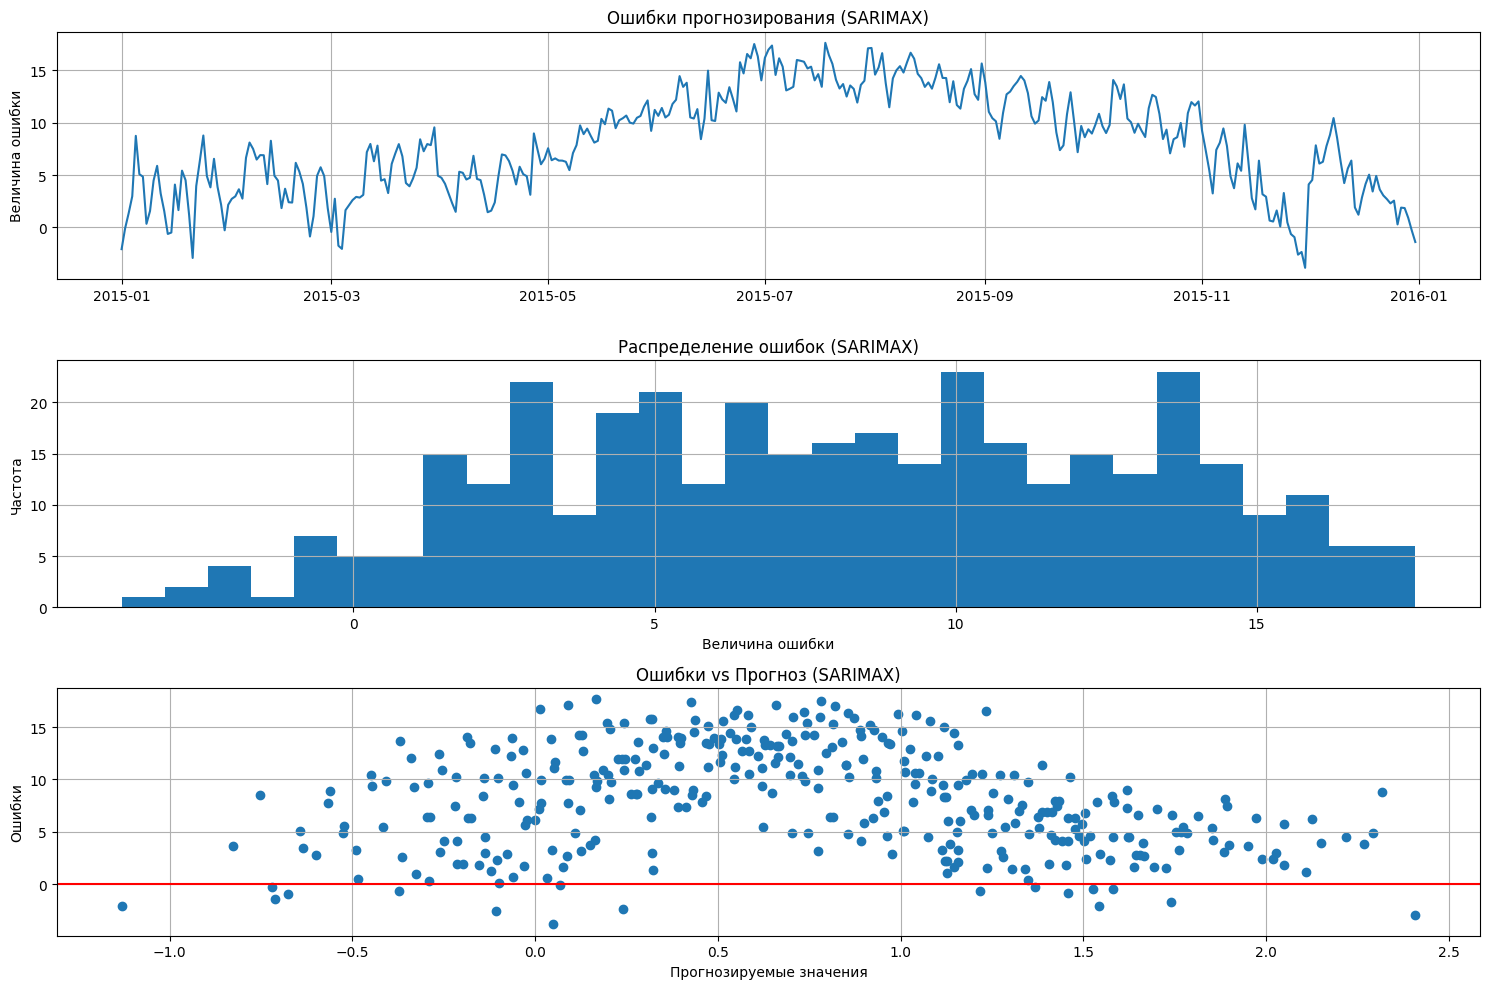

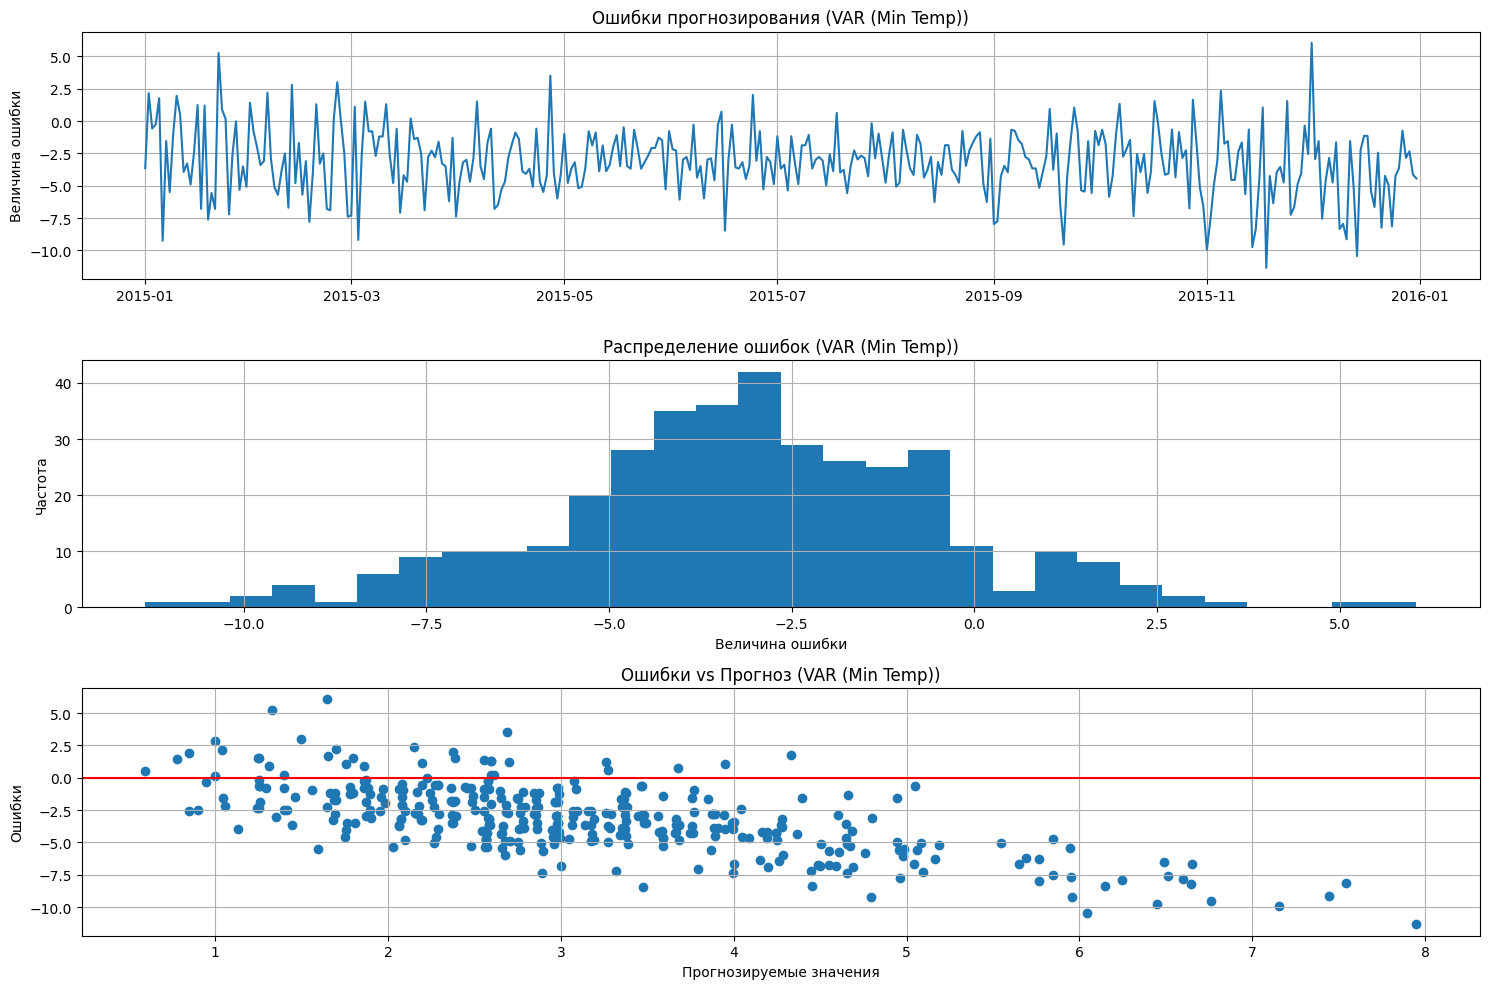

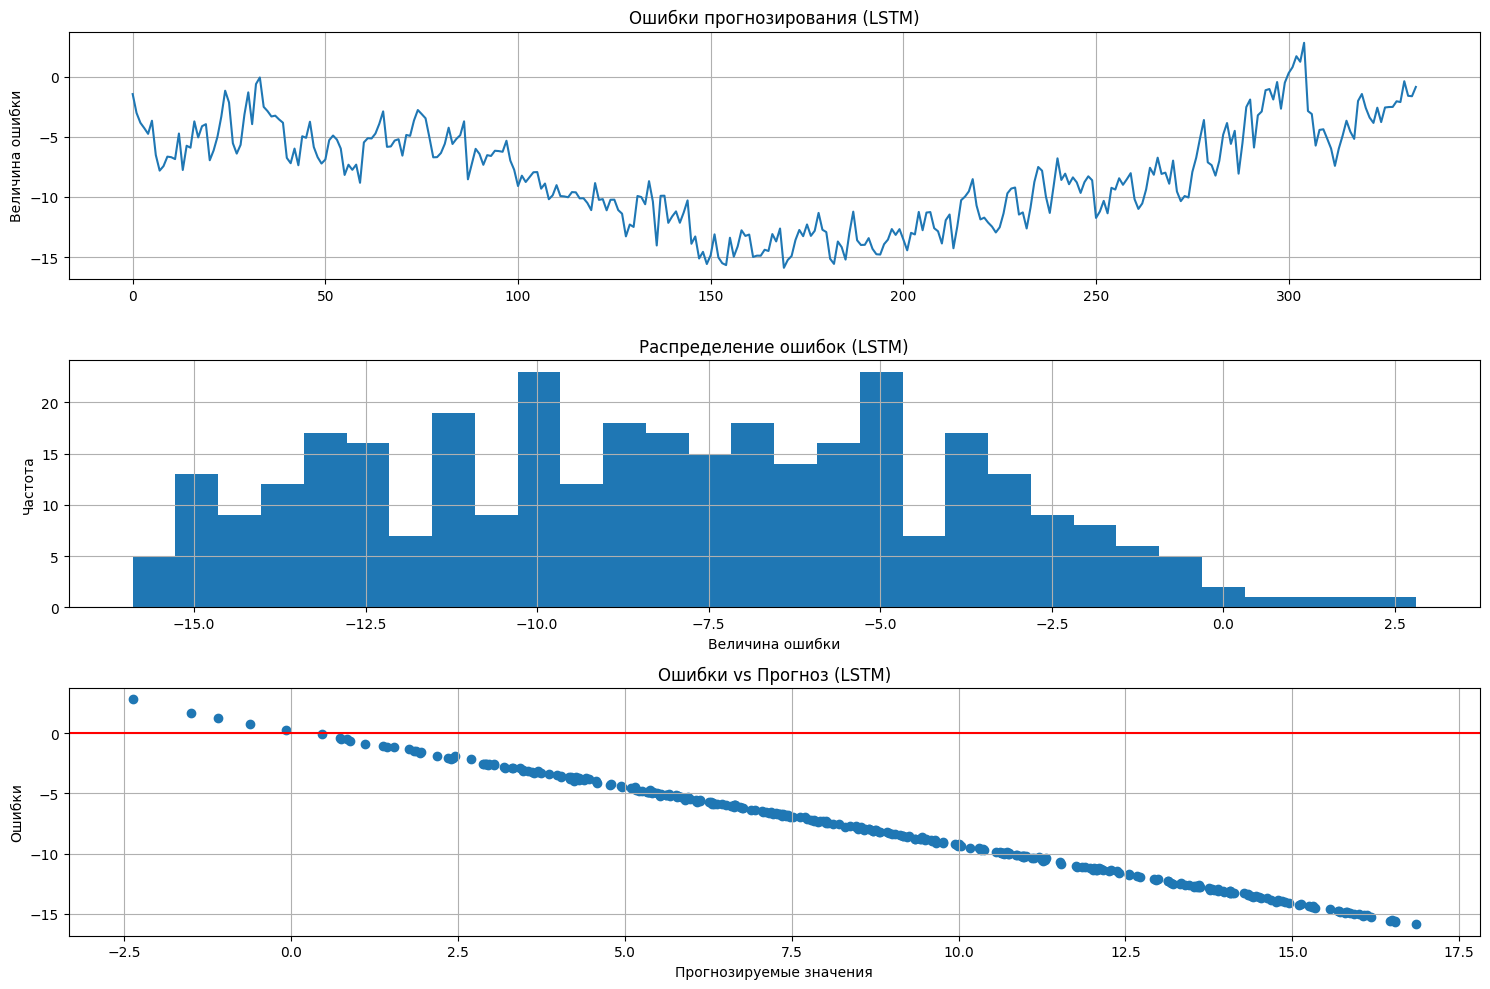

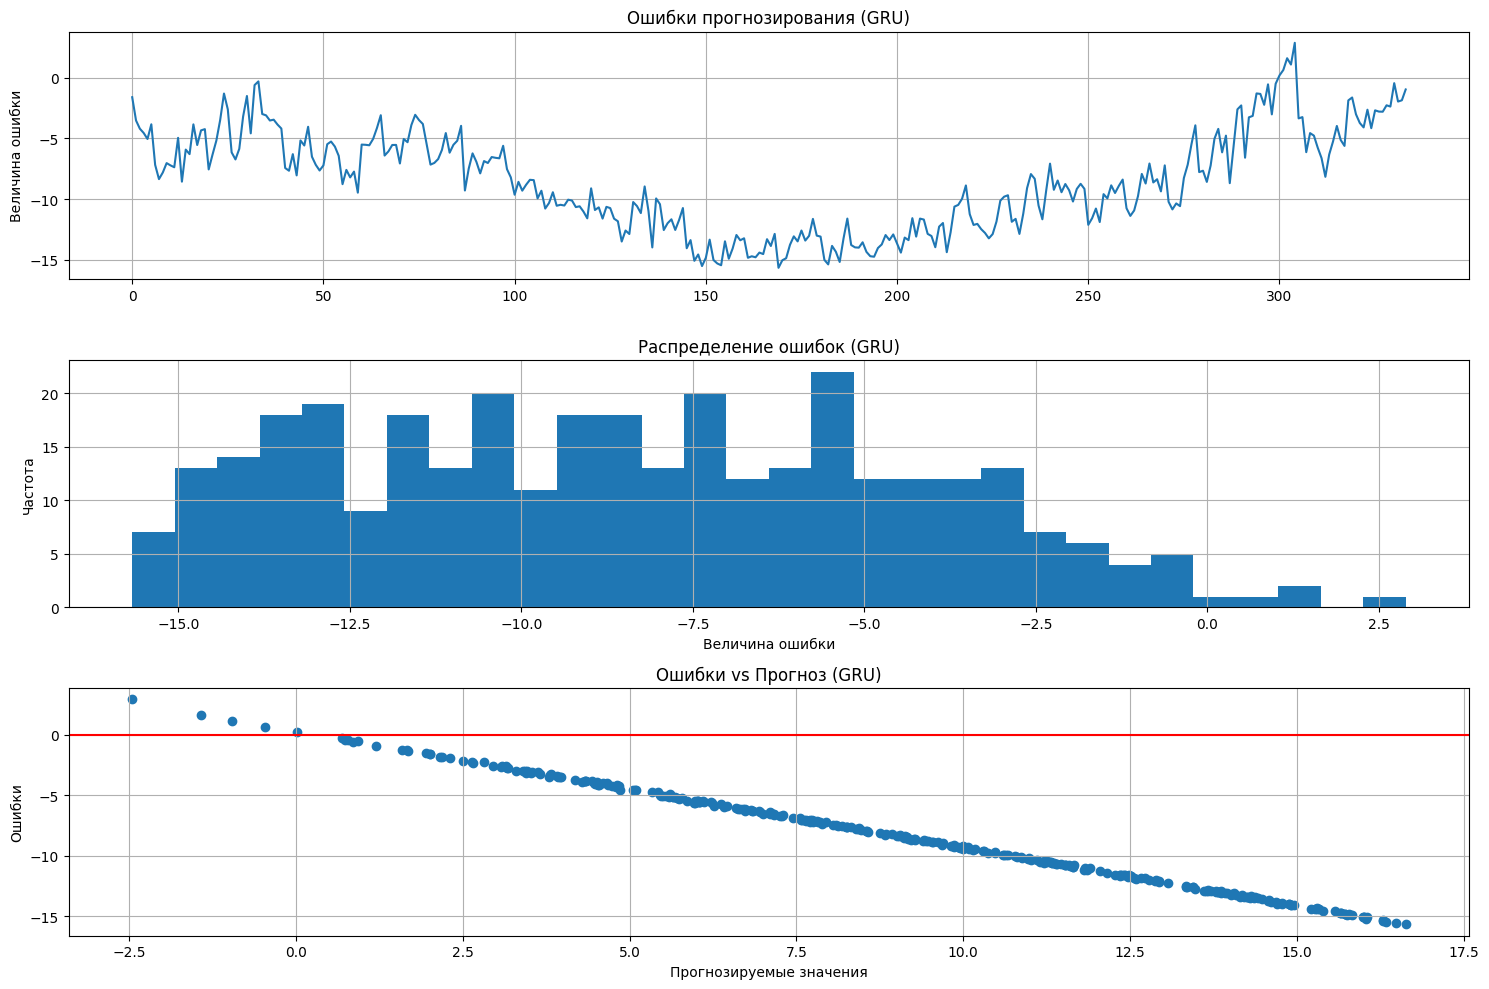

In [62]:
#построениt графиков ошибок
def plot_errors(actual, predicted, model_name):
    errors = actual - predicted
    plt.figure(figsize=(15, 10))

    plt.subplot(3, 1, 1)
    plt.plot(errors)
    plt.title(f'Ошибки прогнозирования ({model_name})')
    plt.ylabel('Величина ошибки')
    plt.grid(True)

    plt.subplot(3, 1, 2)
    plt.hist(errors, bins=30)
    plt.title(f'Распределение ошибок ({model_name})')
    plt.xlabel('Величина ошибки')
    plt.ylabel('Частота')
    plt.grid(True)

    plt.subplot(3, 1, 3)
    plt.scatter(predicted, errors)
    plt.title(f'Ошибки vs Прогноз ({model_name})')
    plt.xlabel('Прогнозируемые значения')
    plt.ylabel('Ошибки')
    plt.axhline(y=0, color='r', linestyle='-')
    plt.grid(True)

    plt.tight_layout()
    plt.show()

# ARIMA
arima_errors = test - forecast_arima
plot_errors(test, forecast_arima, 'ARIMA')

#SARIMAX
sarimax_errors = test - forecast_sarimax
plot_errors(test, forecast_sarimax, 'SARIMAX')

#VAR (для минимальной температуры)
var_errors = test_var['temp_min'] - forecast_var[col]
plot_errors(test_var['temp_min'], forecast_var[col], 'VAR (Min Temp)')

#LSTM
lstm_errors = y_test.flatten() - lstm_forecast.flatten()
plot_errors(y_test.flatten(), lstm_forecast.flatten(), 'LSTM')

#GRU
gru_errors = y_test.flatten() - gru_forecast.flatten()
plot_errors(y_test.flatten(), gru_forecast.flatten(), 'GRU')